In [1]:
# for debug
%reload_ext autoreload
%autoreload 2

In [2]:
from PASCode import PASCode

2023-04-28 14:25:54.869328: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-28 14:25:54.914154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 14:25:55.740496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import scanpy as sc
import torch
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import random
import anndata
import numpy as np
import pandas as pd
import pyreadr
import gc

In [4]:
############################################################################### 
################################### Data reading ##############################
###############################################################################
data_path = '/home/athan/PASCode/data/ROSMAP/mit.self.org.RData'
print("Reading data...")
rdata = pyreadr.read_r(data_path)

Reading data...


In [5]:
############################################################################### 
################################### Data preprocessing ########################
###############################################################################
print('Preprocessing data...')
gxp = pd.concat([rdata['gexpr_AD'], rdata['gexpr_CTL']])
meta = pd.concat([rdata['AD_cells'], rdata['CTL_cells']])
meta.index=meta.TAG
# phenotype is AD(1)/CTL(0)
meta['AD'] = [1]*rdata['gexpr_AD'].shape[0] + [0]*rdata['gexpr_CTL'].shape[0]
meta.tsne1 = meta.tsne1.values.astype(float)
meta.tsne2 = meta.tsne2.values.astype(float)
# select Highly Variable Genes from gene expression data
print("Selecting HVGs...")
agxp = anndata.AnnData(gxp)
sc.pp.highly_variable_genes(agxp, min_mean=.0125, max_mean=3, min_disp=.25)
gxp = gxp.loc[:, agxp.var.highly_variable]
# scaling
print("Scaling...")
scaler = preprocessing.StandardScaler().fit(gxp)
scaled_features = scaler.transform(gxp)
X = pd.DataFrame(scaled_features, columns=gxp.columns, index=gxp.index)
print("Data preprocessing completed.")

Preprocessing data...
Selecting HVGs...
Scaling...
Data preprocessing completed.


In [6]:
############################################################################### 
######################### train, test, validation sets ########################
###############################################################################
pheno_name = 'AD'
sample_id = 'subjectID'
# get sample IDs and phenotypes (list)
group = meta.groupby([sample_id, pheno_name]).size()
group = group[group>0] # filtering
id_pheno = group.index.to_frame()
sample_num = id_pheno.shape[0]
# validation set
val_size = 1/6 # NOTE
val_num_half = int(sample_num*val_size / 2)
val_set = pd.DataFrame({
    sample_id:random.sample(list(id_pheno[id_pheno[pheno_name]==0][sample_id]), val_num_half) 
           + random.sample(list(id_pheno[id_pheno[pheno_name]==1][sample_id]), val_num_half),
    'phenotype':[0]*val_num_half + [1]*val_num_half})
# train/test set
train_test_set = id_pheno[~(id_pheno[sample_id].isin(val_set[sample_id]))]
X_train_test = X[meta[sample_id].isin(train_test_set[sample_id])]
meta_train_test = meta[meta[sample_id].isin(train_test_set[sample_id])]

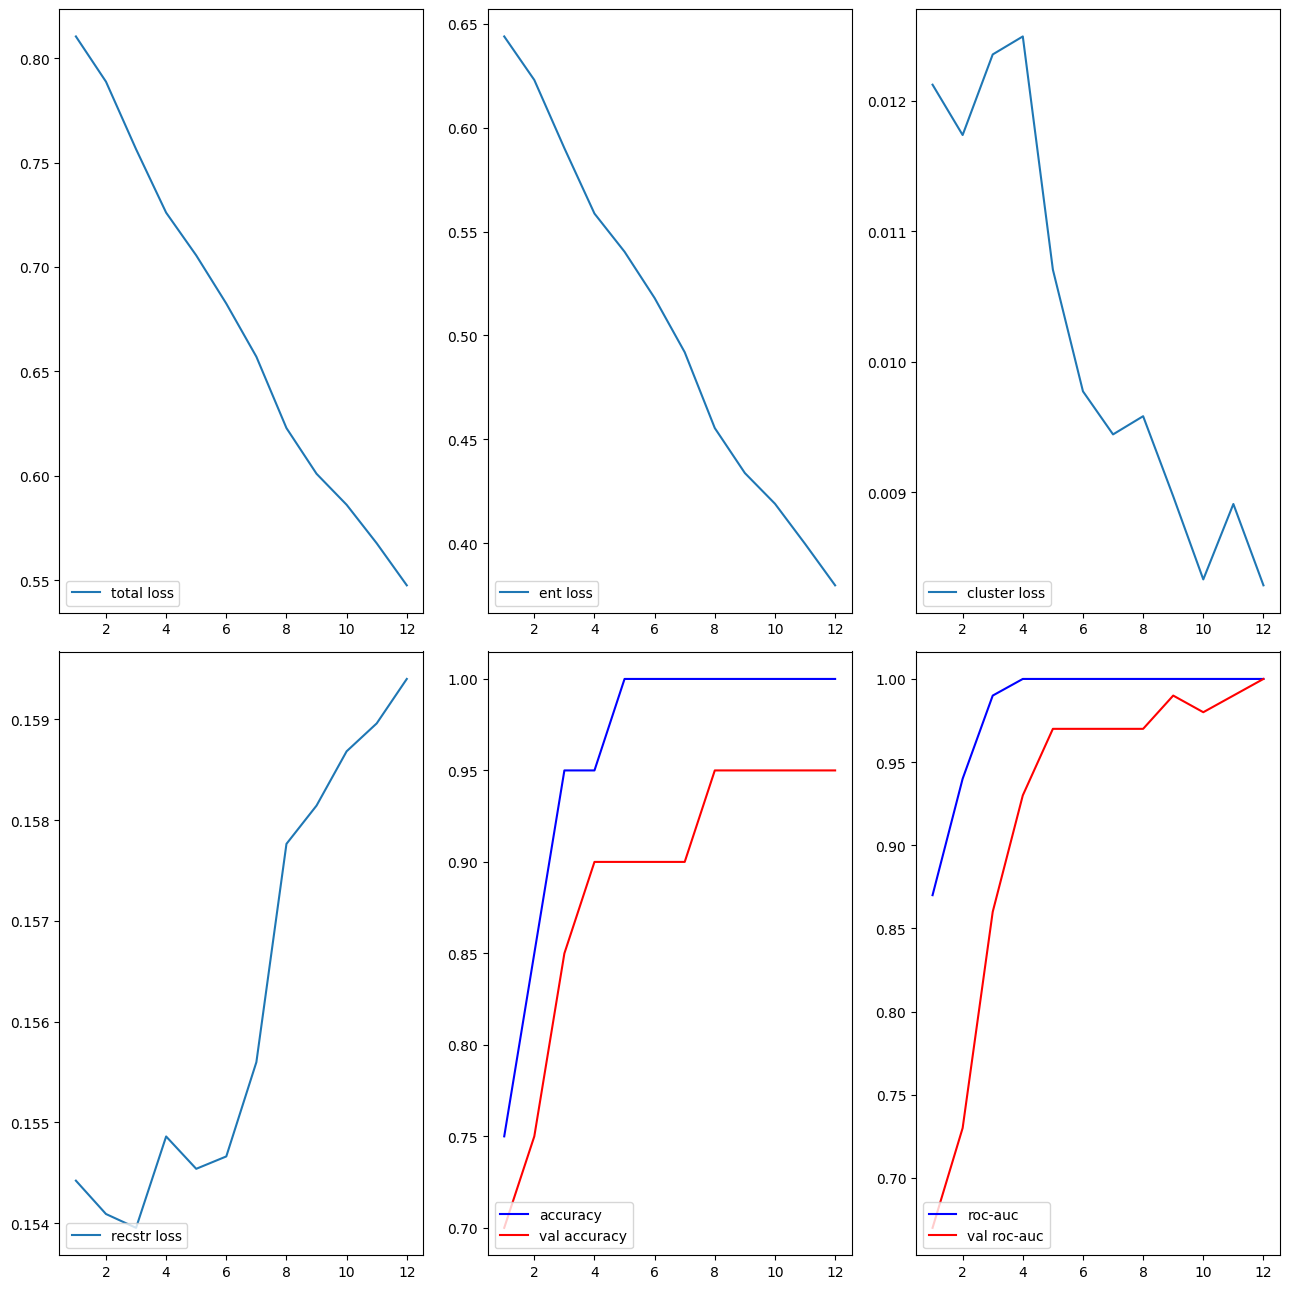

Training complete.

0.95


<Figure size 640x480 with 0 Axes>

In [35]:
############################################################################### 
############################### Cross validation ##############################
############################################################################### 
skf = StratifiedKFold(n_splits=2, shuffle=True)
cv_acc = np.array([])
iter_num = 0

for train_index, test_index in skf.split(train_test_set[sample_id], train_test_set[pheno_name]):
    iter_num += 1
    print('#'*39 + " Fold " + str(iter_num) + ' ' + '#'*39)
    print("Training index:", train_index, "\ntraining index:", test_index)

    train_sample = [train_test_set[sample_id][i] for i in train_index]
    test_sample = [train_test_set[sample_id][i] for i in test_index]
    train_filter = meta_train_test[sample_id].isin(train_sample).values
    test_filter = meta_train_test[sample_id].isin(test_sample).values
    X_train = torch.tensor(X_train_test.loc[train_filter].values)
    meta_train = meta_train_test[train_filter]
    id_train = meta_train[sample_id].values
    y_train = torch.tensor(meta_train[pheno_name].values)
    X_test = torch.tensor(X_train_test.loc[test_filter].values)
    meta_test = meta_train_test[test_filter]
    id_test = meta_test[sample_id].values
    y_test = torch.tensor(meta_test[pheno_name].values)
    
    # use model
    model = PASCode(device='cuda') # 'cuda' or 'cpu', default 'cpu'
    model.train(X_train, y_train)

    # if want to print evaluation
    model.train(X_train, y_train, 
                
                evaluation=True, plot_evaluation=True,
                X_test = X_test, y_test = y_test, id_train=id_train, id_test=id_test,  # to print learning plot
                fold_num=iter_num,) # to save learning plot

    cv_acc = np.append(cv_acc, model.accuracy_test[-1])

    # clean up GPU
    del X_train, y_train, y_test, meta_train, id_train, train_filter, test_filter
    gc.collect()
    torch.cuda.empty_cache()

print(np.mean(cv_acc))

 # Visualization

 ## UMAP on test data

In [36]:
embd_test = model.get_embedding(X_test, reducer='umap')

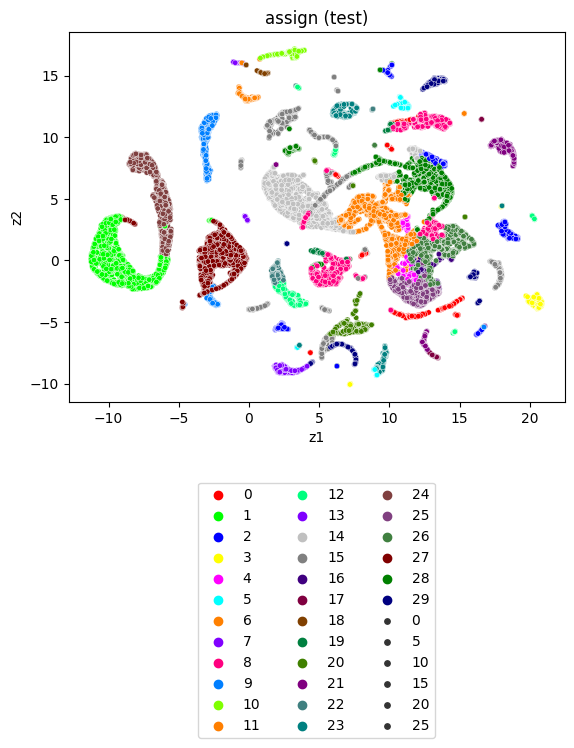

In [37]:
meta_test['assign'] = model.get_assigns(X_test)
model.plot_embedding(X=embd_test, y=meta_test['assign'].values, label='assign', title='assign (test)', require_distinguishable_colors=True)

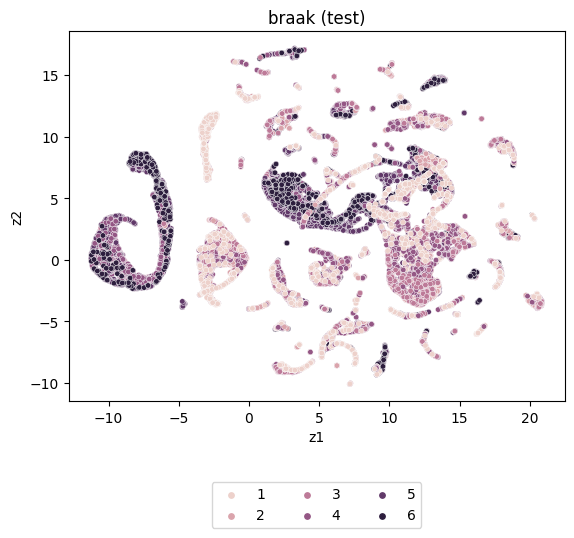

In [38]:
model.plot_embedding(X=embd_test, y=meta_test['braaksc'].values, label='braak', title='braak (test)', require_distinguishable_colors=False)

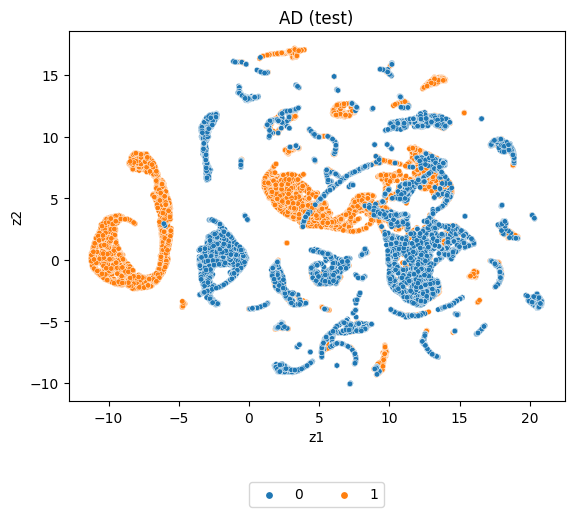

In [39]:
model.plot_embedding(X=embd_test, y=meta_test['AD'].values, label='AD', title='AD (test)', require_distinguishable_colors=False)

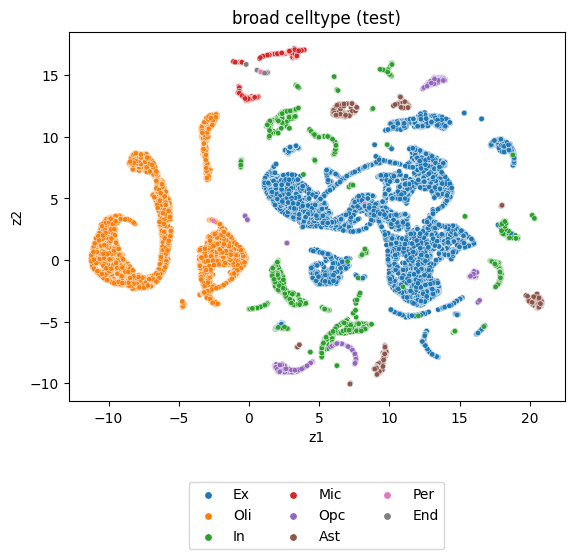

In [40]:
model.plot_embedding(X=embd_test, y=meta_test['broad.cell.type'].values, label='broad celltype', title='broad celltype (test)', require_distinguishable_colors=False)

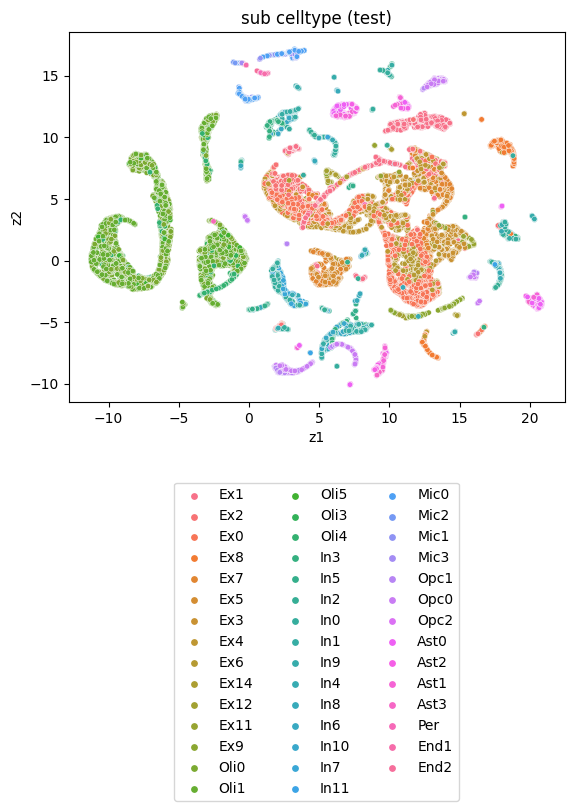

In [41]:
model.plot_embedding(X=embd_test, y=meta_test['Subcluster'].values, label='subcelltype', title='sub celltype (test)', require_distinguishable_colors=False)